In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

**Business question**
<p>Can we accurately predict the stock levels of products based on sales data and sensor data on an hourly basis in order to more intelligently procure products from our suppliers?</p>

## Data loading

In [2]:
def loading_data():
    col_to_drop = ['Unnamed: 0']
    sales = pd.read_csv('data/sales.csv').drop(col_to_drop, axis =1 )
    sales_stock_lvls = pd.read_csv('data/sensor_stock_levels.csv').drop(col_to_drop, axis =1 )
    sensor_stor_temp = pd.read_csv('data/sensor_storage_temperature.csv').drop(col_to_drop, axis =1 )
    
    return sales, sales_stock_lvls, sensor_stor_temp


sales, sales_stock_lvls, sensor_stor_temp = loading_data()
sales.head()

,transaction_id,timestamp,product_id,category,customer_type,unit_price,quantity,total,payment_type
0,a1c82654-c52c-45b3-8ce8-4c2a1efe63ed,2022-03-02 09:51:38,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,gold,3.99,2,7.98,e-wallet
1,931ad550-09e8-4da6-beaa-8c9d17be9c60,2022-03-06 10:33:59,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,fruit,standard,3.99,1,3.99,e-wallet
2,ae133534-6f61-4cd6-b6b8-d1c1d8d90aea,2022-03-04 17:20:21,7c55cbd4-f306-4c04-a030-628cbe7867c1,fruit,premium,0.19,2,0.38,e-wallet
3,157cebd9-aaf0-475d-8a11-7c8e0f5b76e4,2022-03-02 17:23:58,80da8348-1707-403f-8be7-9e6deeccc883,fruit,gold,0.19,4,0.76,e-wallet
4,a81a6cd3-5e0c-44a2-826c-aea43e46c514,2022-03-05 14:32:43,7f5e86e6-f06f-45f6-bf44-27b095c9ad1d,fruit,basic,4.49,2,8.98,debit card


In [3]:
sales_stock_lvls.head()

,id,timestamp,product_id,estimated_stock_pct
0,4220e505-c247-478d-9831-6b9f87a4488a,2022-03-07 12:13:02,f658605e-75f3-4fed-a655-c0903f344427,0.75
1,f2612b26-fc82-49ea-8940-0751fdd4d9ef,2022-03-07 16:39:46,de06083a-f5c0-451d-b2f4-9ab88b52609d,0.48
2,989a287f-67e6-4478-aa49-c3a35dac0e2e,2022-03-01 18:17:43,ce8f3a04-d1a4-43b1-a7c2-fa1b8e7674c8,0.58
3,af8e5683-d247-46ac-9909-1a77bdebefb2,2022-03-02 14:29:09,c21e3ba9-92a3-4745-92c2-6faef73223f7,0.79
4,08a32247-3f44-4002-85fb-c198434dd4bb,2022-03-02 13:46:18,7f478817-aa5b-44e9-9059-8045228c9eb0,0.22


In [4]:
sensor_stor_temp.head()

,id,timestamp,temperature
0,d1ca1ef8-0eac-42fc-af80-97106efc7b13,2022-03-07 15:55:20,2.96
1,4b8a66c4-0f3a-4f16-826f-8cf9397e9d18,2022-03-01 09:18:22,1.88
2,3d47a0c7-1e72-4512-812f-b6b5d8428cf3,2022-03-04 15:12:26,1.78
3,9500357b-ce15-424a-837a-7677b386f471,2022-03-02 12:30:42,2.18
4,c4b61fec-99c2-4c6d-8e5d-4edd8c9632fa,2022-03-05 09:09:33,1.38


# Data preparation

In [5]:
sales.info() # here we don`t have empty cols

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7829 entries, 0 to 7828
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  7829 non-null   object 
 1   timestamp       7829 non-null   object 
 2   product_id      7829 non-null   object 
 3   category        7829 non-null   object 
 4   customer_type   7829 non-null   object 
 5   unit_price      7829 non-null   float64
 6   quantity        7829 non-null   int64  
 7   total           7829 non-null   float64
 8   payment_type    7829 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 550.6+ KB


In [6]:
sales_stock_lvls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  object 
 1   timestamp            15000 non-null  object 
 2   product_id           15000 non-null  object 
 3   estimated_stock_pct  15000 non-null  float64
dtypes: float64(1), object(3)
memory usage: 468.9+ KB


In [7]:
sensor_stor_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23890 entries, 0 to 23889
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           23890 non-null  object 
 1   timestamp    23890 non-null  object 
 2   temperature  23890 non-null  float64
dtypes: float64(1), object(2)
memory usage: 560.0+ KB


In [8]:
# let's convert data objects to datetime objects
def convert(data: pd.DataFrame = None, column: str = None):

  data[column] = pd.to_datetime(data[column], format='%Y-%m-%d %H:%M:%S')
  return data


In [9]:
# change timestamp in sales
sales = convert(sales, 'timestamp')
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7829 entries, 0 to 7828
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  7829 non-null   object        
 1   timestamp       7829 non-null   datetime64[ns]
 2   product_id      7829 non-null   object        
 3   category        7829 non-null   object        
 4   customer_type   7829 non-null   object        
 5   unit_price      7829 non-null   float64       
 6   quantity        7829 non-null   int64         
 7   total           7829 non-null   float64       
 8   payment_type    7829 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 550.6+ KB


In [10]:
# change timestamp in sales_stock_lvls
sales_stock_lvls = convert(sales_stock_lvls, 'timestamp')
sales_stock_lvls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   15000 non-null  object        
 1   timestamp            15000 non-null  datetime64[ns]
 2   product_id           15000 non-null  object        
 3   estimated_stock_pct  15000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 468.9+ KB


In [11]:
sensor_stor_temp = convert(sensor_stor_temp, 'timestamp')
sensor_stor_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23890 entries, 0 to 23889
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           23890 non-null  object        
 1   timestamp    23890 non-null  datetime64[ns]
 2   temperature  23890 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 560.0+ KB


# Aggregating data

In [12]:
# this part of code I copied
from datetime import datetime

def convert_timestamp_to_hourly(data: pd.DataFrame = None, column: str = None):
  dummy = data.copy()
  new_ts = dummy[column].tolist()
  new_ts = [i.strftime('%Y-%m-%d %H:00:00') for i in new_ts]
  new_ts = [datetime.strptime(i, '%Y-%m-%d %H:00:00') for i in new_ts]
  dummy[column] = new_ts
  return dummy

In [13]:
sales = convert_timestamp_to_hourly(sales, 'timestamp')
sales.head()

,transaction_id,timestamp,product_id,category,customer_type,unit_price,quantity,total,payment_type
0,a1c82654-c52c-45b3-8ce8-4c2a1efe63ed,2022-03-02 09:00:00,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,gold,3.99,2,7.98,e-wallet
1,931ad550-09e8-4da6-beaa-8c9d17be9c60,2022-03-06 10:00:00,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,fruit,standard,3.99,1,3.99,e-wallet
2,ae133534-6f61-4cd6-b6b8-d1c1d8d90aea,2022-03-04 17:00:00,7c55cbd4-f306-4c04-a030-628cbe7867c1,fruit,premium,0.19,2,0.38,e-wallet
3,157cebd9-aaf0-475d-8a11-7c8e0f5b76e4,2022-03-02 17:00:00,80da8348-1707-403f-8be7-9e6deeccc883,fruit,gold,0.19,4,0.76,e-wallet
4,a81a6cd3-5e0c-44a2-826c-aea43e46c514,2022-03-05 14:00:00,7f5e86e6-f06f-45f6-bf44-27b095c9ad1d,fruit,basic,4.49,2,8.98,debit card


In [14]:
sales_stock_lvls = convert_timestamp_to_hourly(sales_stock_lvls, 'timestamp')
sales_stock_lvls.head()

,id,timestamp,product_id,estimated_stock_pct
0,4220e505-c247-478d-9831-6b9f87a4488a,2022-03-07 12:00:00,f658605e-75f3-4fed-a655-c0903f344427,0.75
1,f2612b26-fc82-49ea-8940-0751fdd4d9ef,2022-03-07 16:00:00,de06083a-f5c0-451d-b2f4-9ab88b52609d,0.48
2,989a287f-67e6-4478-aa49-c3a35dac0e2e,2022-03-01 18:00:00,ce8f3a04-d1a4-43b1-a7c2-fa1b8e7674c8,0.58
3,af8e5683-d247-46ac-9909-1a77bdebefb2,2022-03-02 14:00:00,c21e3ba9-92a3-4745-92c2-6faef73223f7,0.79
4,08a32247-3f44-4002-85fb-c198434dd4bb,2022-03-02 13:00:00,7f478817-aa5b-44e9-9059-8045228c9eb0,0.22


In [15]:

sensor_stor_temp = convert_timestamp_to_hourly(sensor_stor_temp, 'timestamp')
sensor_stor_temp.head()

,id,timestamp,temperature
0,d1ca1ef8-0eac-42fc-af80-97106efc7b13,2022-03-07 15:00:00,2.96
1,4b8a66c4-0f3a-4f16-826f-8cf9397e9d18,2022-03-01 09:00:00,1.88
2,3d47a0c7-1e72-4512-812f-b6b5d8428cf3,2022-03-04 15:00:00,1.78
3,9500357b-ce15-424a-837a-7677b386f471,2022-03-02 12:00:00,2.18
4,c4b61fec-99c2-4c6d-8e5d-4edd8c9632fa,2022-03-05 09:00:00,1.38


Now Im going to aggregate product id by hour whet it was bought

In [16]:
sales_agg = sales.groupby(['timestamp', 'product_id']).agg({'quantity': 'sum'}).reset_index()
sales_agg.head()

,timestamp,product_id,quantity
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,3
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,3
2,2022-03-01 09:00:00,03a2557a-aa12-4add-a6d4-77dc36342067,3
3,2022-03-01 09:00:00,049b2171-0eeb-4a3e-bf98-0c290c7821da,7
4,2022-03-01 09:00:00,04da844d-8dba-4470-9119-e534d52a03a0,11


In [17]:
sales_stock_agg = sales_stock_lvls.groupby(['timestamp', 'product_id']).agg(
    {'estimated_stock_pct': 'mean'}).reset_index()
sales_stock_agg.head()

,timestamp,product_id,estimated_stock_pct
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05


In [18]:
sensor_stor_temp = sensor_stor_temp.groupby(['timestamp']).agg({"temperature": 'mean'}).reset_index()
sensor_stor_temp.head()

,timestamp,temperature
0,2022-03-01 09:00:00,-0.028850
1,2022-03-01 10:00:00,1.284314
2,2022-03-01 11:00:00,-0.560000
3,2022-03-01 12:00:00,-0.537721
4,2022-03-01 13:00:00,-0.188734


# Merging data

In [19]:
merged_df = sales_stock_agg.merge(sales_agg, on=['timestamp', 'product_id'], how='left')
merged_df = merged_df.merge(sensor_stor_temp, on='timestamp', how='left')
merged_df

,timestamp,product_id,estimated_stock_pct,quantity,temperature
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.028850
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.028850
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,NaN,-0.028850
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,NaN,-0.028850
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,NaN,-0.028850
...,...,...,...,...,...
10840,2022-03-07 19:00:00,ecac012c-1dec-41d4-9ebd-56fb7166f6d9,0.50,4.0,-0.165077
10841,2022-03-07 19:00:00,ed7f6b14-67c9-42a4-8576-c803020eedda,0.26,NaN,-0.165077
10842,2022-03-07 19:00:00,edf4ac93-4e14-4a3d-8c60-e715210cf3f9,0.78,3.0,-0.165077
10843,2022-03-07 19:00:00,f01b189c-6345-4639-a8d1-89e1fc67c443,0.92,3.0,-0.165077


So we created our dataset for feature engineering and modeling. But before it let's clear our data or fill empty values

In [20]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10845 entries, 0 to 10844
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            10845 non-null  datetime64[ns]
 1   product_id           10845 non-null  object        
 2   estimated_stock_pct  10845 non-null  float64       
 3   quantity             3067 non-null   float64       
 4   temperature          10845 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 508.4+ KB


After filling empty values I should change type of quantity , because it is float64, we cannot buy half of product

In [21]:
merged_df['quantity'] = merged_df.quantity.fillna(merged_df.quantity.mean())
merged_df['quantity'] = merged_df.quantity.astype('int8')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10845 entries, 0 to 10844
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            10845 non-null  datetime64[ns]
 1   product_id           10845 non-null  object        
 2   estimated_stock_pct  10845 non-null  float64       
 3   quantity             10845 non-null  int8          
 4   temperature          10845 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int8(1), object(1)
memory usage: 434.2+ KB


Next I wanna merge our data with other features, that we left in datasets

In [22]:
# Here I copied code, because it's clear, so why should I write it by myself? ahahhaha
product_categories = sales[['product_id', 'category']]
product_categories = product_categories.drop_duplicates()

product_price = sales[['product_id', 'unit_price']]
product_price = product_price.drop_duplicates()

In [23]:
merged_df = merged_df.merge(product_categories, how='left', on='product_id')
merged_df = merged_df.merge(product_price, how='left', on='product_id')
merged_df.info() # here everything is alright with our data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10845 entries, 0 to 10844
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            10845 non-null  datetime64[ns]
 1   product_id           10845 non-null  object        
 2   estimated_stock_pct  10845 non-null  float64       
 3   quantity             10845 non-null  int8          
 4   temperature          10845 non-null  float64       
 5   category             10845 non-null  object        
 6   unit_price           10845 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int8(1), object(2)
memory usage: 603.7+ KB


# Feature engineering

In [24]:
class FeatureEngineering():

    def __init__(self, data):
        self.data = data                                         
        
        
    def creating_new_features(self):
        self.data = self.data.drop(['product_id'], axis = 1) # I delete this column, because in future it will skew our 
                                                    # model and encoding will create myriad features
        self.data['day_of_week'] = self.data.timestamp.apply(lambda x: x.day)
        self.data['month'] = self.data.timestamp.apply(lambda x: x.month)
        self.data['hour'] = self.data.timestamp.apply(lambda x: x.hour)
        
        return self.data
    
    def custom_combiner(self, feature, category): 
        return str(feature) + "_" + type(category).__name__ + "_" + str(category)
    
    def encoding(self):
        enc = OneHotEncoder(feature_name_combiner=self.custom_combiner, sparse = False)
        categorical_features = self.data.select_dtypes(include=['object']).columns.to_list()
        transformed = enc.fit_transform(self.data[categorical_features])
        self.data[enc.get_feature_names_out()] = transformed
        
        return self.data
                                                       
    def scalling(self):
        scaller = StandardScaler()
        numerical_features = self.data.select_dtypes(include=['float64', 'int8']).columns.to_list()
        transformed = scaller.fit_transform(self.data[numerical_features])
        new_features = ['std_'+i for i in numerical_features]
        
        self.data[new_features] = transformed

        return self.data

    def get_result(self):
        self.data = self.scalling()
        self.data = self.creating_new_features()
        self.data = self.encoding()
        
        
        return self.data
        

In [25]:
fe = FeatureEngineering(merged_df)
merged_df = fe.get_result()
merged_df

/home/jollyreap/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,timestamp,estimated_stock_pct,quantity,temperature,category,unit_price,std_estimated_stock_pct,std_quantity,std_temperature,std_unit_price,...,category_str_meat,category_str_medicine,category_str_packaged foods,category_str_personal care,category_str_pets,category_str_refrigerated items,category_str_seafood,category_str_snacks,category_str_spices and herbs,category_str_vegetables
0,2022-03-01 09:00:00,0.89,3,-0.028850,kitchen,11.19,1.455047,-0.057028,0.284508,0.417705,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-03-01 09:00:00,0.14,3,-0.028850,vegetables,1.49,-1.380416,-0.057028,0.284508,-1.381928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2022-03-01 09:00:00,0.67,3,-0.028850,baby products,14.19,0.623311,-0.057028,0.284508,0.974293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-03-01 09:00:00,0.82,3,-0.028850,beverages,20.19,1.190403,-0.057028,0.284508,2.087468,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-03-01 09:00:00,0.05,3,-0.028850,pets,8.19,-1.720672,-0.057028,0.284508,-0.138883,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10840,2022-03-07 19:00:00,0.50,4,-0.165077,fruit,4.99,-0.019394,0.891545,0.074811,-0.732576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10841,2022-03-07 19:00:00,0.26,3,-0.165077,meat,19.99,-0.926742,-0.057028,0.074811,2.050362,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10842,2022-03-07 19:00:00,0.78,3,-0.165077,packaged foods,6.99,1.039179,-0.057028,0.074811,-0.361518,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10843,2022-03-07 19:00:00,0.92,3,-0.165077,meat,14.99,1.568465,-0.057028,0.074811,1.122716,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next I'm going to drop some columns

In [26]:

renamed_feats = {}
for feature in merged_df.columns.to_list():
    renamed_feats[feature] = feature.replace(' ', '_')

merged_df = merged_df.drop(['timestamp', 'category', 'unit_price', 'quantity'], axis=1)
merged_df = merged_df.rename(columns=renamed_feats)
merged_df

,estimated_stock_pct,temperature,std_estimated_stock_pct,std_quantity,std_temperature,std_unit_price,day_of_week,month,hour,category_str_baby_products,...,category_str_meat,category_str_medicine,category_str_packaged_foods,category_str_personal_care,category_str_pets,category_str_refrigerated_items,category_str_seafood,category_str_snacks,category_str_spices_and_herbs,category_str_vegetables
0,0.89,-0.028850,1.455047,-0.057028,0.284508,0.417705,1,3,9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.14,-0.028850,-1.380416,-0.057028,0.284508,-1.381928,1,3,9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.67,-0.028850,0.623311,-0.057028,0.284508,0.974293,1,3,9,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.82,-0.028850,1.190403,-0.057028,0.284508,2.087468,1,3,9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.05,-0.028850,-1.720672,-0.057028,0.284508,-0.138883,1,3,9,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10840,0.50,-0.165077,-0.019394,0.891545,0.074811,-0.732576,7,3,19,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10841,0.26,-0.165077,-0.926742,-0.057028,0.074811,2.050362,7,3,19,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10842,0.78,-0.165077,1.039179,-0.057028,0.074811,-0.361518,7,3,19,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10843,0.92,-0.165077,1.568465,-0.057028,0.074811,1.122716,7,3,19,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling

In [27]:
X = merged_df.drop(['estimated_stock_pct', 'std_estimated_stock_pct', 'temperature'], axis = 1)
y = merged_df.estimated_stock_pct

X

,std_quantity,std_temperature,std_unit_price,day_of_week,month,hour,category_str_baby_products,category_str_baked_goods,category_str_baking,category_str_beverages,...,category_str_meat,category_str_medicine,category_str_packaged_foods,category_str_personal_care,category_str_pets,category_str_refrigerated_items,category_str_seafood,category_str_snacks,category_str_spices_and_herbs,category_str_vegetables
0,-0.057028,0.284508,0.417705,1,3,9,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.057028,0.284508,-1.381928,1,3,9,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.057028,0.284508,0.974293,1,3,9,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.057028,0.284508,2.087468,1,3,9,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.057028,0.284508,-0.138883,1,3,9,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10840,0.891545,0.074811,-0.732576,7,3,19,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10841,-0.057028,0.074811,2.050362,7,3,19,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10842,-0.057028,0.074811,-0.361518,7,3,19,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10843,-0.057028,0.074811,1.122716,7,3,19,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Here let's implement something like cross val score
mapes = []

for i in range(10):
    model = RandomForestRegressor()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, shuffle = True)
    trained_model = model.fit(X_train, y_train)
    
    y_pred = trained_model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f'Fold: {i+1}, MAPE: {mape:.3f}')
    
    mapes.append(mape)
    
print(f'Average of MAPE: {sum(mapes) / len(mapes):.3f}')
    


Fold: 1, MAPE: 1.573
Fold: 2, MAPE: 1.570
Fold: 3, MAPE: 1.569
Fold: 4, MAPE: 1.579
Fold: 5, MAPE: 1.562
Fold: 6, MAPE: 1.585
Fold: 7, MAPE: 1.547
Fold: 8, MAPE: 1.630
Fold: 9, MAPE: 1.572
Fold: 10, MAPE: 1.610
Average of MAPE: 1.580


Let's visualize feature importances and make conclusions

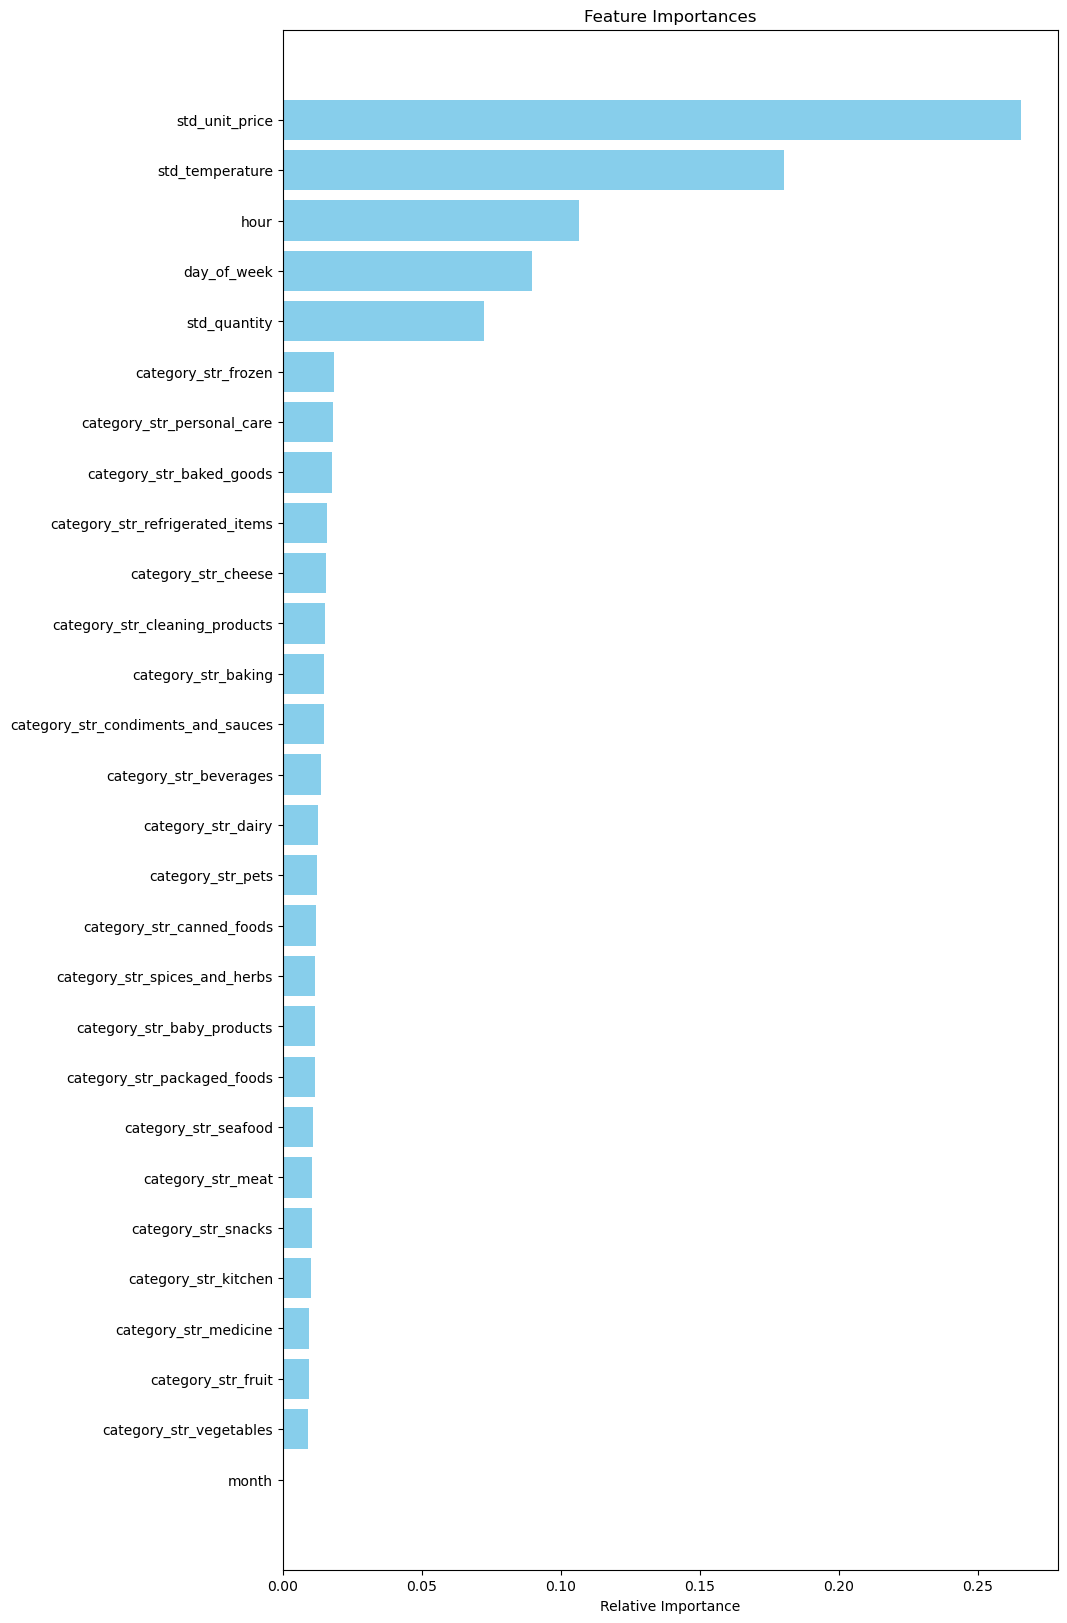

In [29]:
features = [i.split("__")[0] for i in X.columns]
importances = model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10, 20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='skyblue', align='center', linewidth=3)
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Model shows good result. It predicts values with low error on different samples. 

Analysis of plot:
- The most important features are price, hour and std_temperature
- As it was expected categorical data aren't so important
- Month is absolutely unnecessary feature

That's all about this plot and model. Thanks!